In [1]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import sys
import glob
import matplotlib as plt
from skimage import data, io, filters
from tensorflow.python import keras as keras
import os

In [2]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

def parser(record):
    keys_to_features = {
        "image_raw": tf.FixedLenFeature([], tf.string),
        "label":     tf.FixedLenFeature([4], tf.int64),
        "classes":   tf.FixedLenFeature([1],tf.int64)
    }
    parsed = tf.parse_single_example(record, keys_to_features)
    image = tf.decode_raw(parsed["image_raw"], tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=[480, 640,3])
    label = tf.cast(parsed["label"], tf.float32)
    class_id = tf.cast(parsed['classes'], tf.float32)

    return image, label, class_id

def input_fn(filenames,train, batch_size = 9, buffer_size = 1148):
    dataset = tf.data.TFRecordDataset(filenames=filenames, num_parallel_reads=40)
    dataset = dataset.map(parser, num_parallel_calls=12)
    if train: 
        dataset = dataset.shuffle(buffer_size=buffer_size)
        num_repeat = None
    else:
        num_repeat = 1
    dataset = dataset.repeat(num_repeat)
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    images_batch,labels_batch, classes_batch = iterator.get_next()
    x = images_batch
    y = labels_batch
    z = classes_batch
    return x,y,z

def train_input_fn():
    return input_fn(filenames=["train.tfrecords", "test.tfrecords"], train=True)

def val_input_fn():
    return input_fn(filenames=["val.tfrecords"], train=False)

In [3]:
print(train_input_fn())

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 480, 640, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(?, 4) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(?, 1) dtype=float32>)


In [47]:
import tensorflow as tf
from tensorflow.python import keras as keras

STEPS_PER_EPOCH= int(1148 / 9)
#Get your datatensors
image, label, classes = train_input_fn()
print(classes)

#Combine it with keras
model_input = keras.layers.Input(tensor=image)

#Build your network
model_output = keras.layers.Flatten(input_shape=(-1,480, 640,3))(model_input)
model_output = keras.layers.Dense(4, activation='relu')(model_output)

#Create your model
train_model = keras.models.Model(inputs=model_input, outputs=model_output)

#Compile your model
train_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
                    loss='mean_squared_error',
                    metrics=['accuracy'],
                    target_tensors=[classes])

#Train the model
train_model.fit(epochs=6,
                steps_per_epoch=STEPS_PER_EPOCH)

#More Kerasstuff here

Tensor("IteratorGetNext_2:2", shape=(?, 1), dtype=float32)
Epoch 1/6
 30/127 [======>.......................] - ETA: 36s - loss: 148.7990 - acc: 0.9704

KeyboardInterrupt: 

In [70]:
#%load_ext autoreload
#%autoreload 2


from keras_retinanet import models,losses
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras import backend as K5
from keras.optimizers import adam
from keras.utils import Sequence
# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
K.set_session(get_session())

In [90]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('keras-retinanet','keras_retinanet', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'robot', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

c:\users\jeroe\appdata\local\programs\python\python36\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


processing time:  5.662053108215332


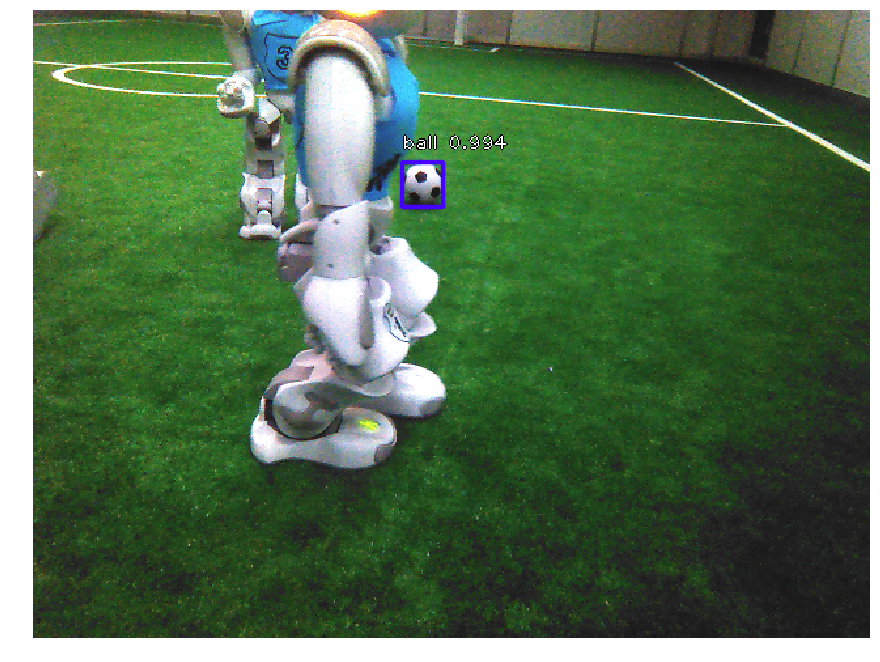

In [37]:
# load image
image = read_image_bgr('01.png')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [76]:
model_test = models.backbone('resnet50').retinanet(num_classes=1)
model_test.compile(
    loss={
        'regression'    : losses.smooth_l1(),
        'classification': losses.focal()
    },
    optimizer = adam(lr=1e-5, clipnorm=0.001)
)
model_test.fit_generator(CSVGenerator('data_annotated.csv','class_mapping.csv'),steps_per_epoch=1148 / 9,epochs=1)

Epoch 1/1
  1/127 [..............................] - ETA: 2:12:49 - loss: 22042.9082 - regression_loss: 697.7329 - classification_loss: 21345.1758

C:\Users\jeroe\AppData\Roaming\Python\Python36\site-packages\keras_retinanet\preprocessing\generator.py:169: UserWarning: Image with id 768 (shape (480, 640, 3)) contains the following invalid boxes: [[559. 422. 640. 481.]].
  annotations['bboxes'][invalid_indices, :]


128/127 [==============================] - 2448s 19s/step - loss: 2743.7586 - regression_loss: 144.4933 - classification_loss: 2599.2653


ValueError: not enough values to unpack (expected 3, got 2)

In [82]:
new_model = models.convert_model(model_test)

processing time:  3.8486075401306152


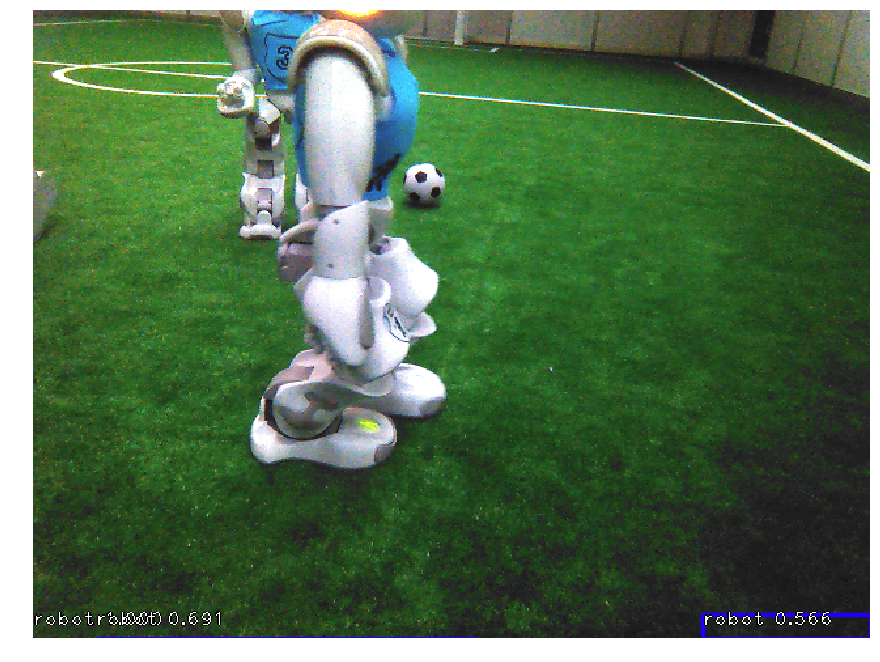

In [87]:
# load image
image = read_image_bgr('01.png')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = new_model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [91]:
#model = models.convert_model(model)
model.compile(
    loss={
        'regression'    : losses.smooth_l1(),
        'classification': losses.focal()
    },
    optimizer = adam(lr=1e-5, clipnorm=0.001)
)
model.fit_generator(CSVGenerator('data_annotated.csv','class_mapping.csv'),steps_per_epoch=1148 / 9,epochs=1)

ValueError: Unknown entry in loss dictionary: "regression". Only expected the following keys: ['filtered_detections', 'filtered_detections', 'filtered_detections']